In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
%matplotlib inline

In [3]:
class activation :
    def __init__(self):
        pass
    def do(self, x):
        pass
    def derivative(self, x):
        pass

In [4]:
class sigmoid(activation):
    def do(self, x):
        return 1/(1+np.exp(-x))
    def derivative(self, x):
        return x*(1-x)

In [5]:
class tanh(activation):
    def do(self, x):
        return np.tanh(x)
    def derivative(self, x):
        return 1-x**2

In [6]:
class relu(activation):
    def do(self, x):
        return np.maximum(0,x)
    def derivative(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

In [24]:
class leaky_relu(activation):
    def __init__(self, alpha = 0.01):
        self.alpha = alpha
    def do(self, x):
        return np.maximum(x*self.alpha,x)
    def derivative(self, x):
        x[x<=0] = self.alpha
        x[x>0] = 1
        return x

In [39]:
class LLayer():
    def __init__(self, layers_dim, activations, learning_rate=0.1):
        self.parameters = {}
        self.A = {}
        self.grads = {}
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.activations = activations
        self.lr = learning_rate
        self.layer_dims = layers_dim
        self.L = len(self.layer_dims)
        
    def initialize_parameters_deep(self):
        for i in range(1, self.L-1):
            self.parameters['W'+str(i)] = np.random.normal(0,1,(self.layer_dims[i-1], self.layer_dims[i])) 
            self.parameters['b'+str(i)] = np.zeros(self.layer_dims[i])
        self.parameters['W'+str(self.L-1)] = np.random.normal(0, 1, (self.layer_dims[self.L-2] , 1)) 
        self.parameters['b'+str(self.L-1)] = 0
            
    def forpass(self, x):
        z = np.dot(x, self.parameters['W1']) + self.parameters['b1']
        self.A['A1'] = self.activations[0].do(z)
        
        for i in range(2, self.L):
            z = np.dot(self.A['A'+str(i-1)], self.parameters['W'+str(i)]) + self.parameters['b'+str(i)]
            self.A['A'+str(i)] = self.activations[i-1].do(z)
        
        return self.A['A'+str(self.L-1)]

    def backprop(self, x, err):
        m = len(x)
        
        self.grads['dW'+str(self.L - 1)] = np.dot(self.A['A'+str(self.L - 2)].T, err) / m
        self.grads['db'+str(self.L - 1)] = np.sum(err) / m
        err_hidden = np.dot(err, self.parameters['W'+str(self.L - 1)].T) * self.activations[self.L-3].derivative(self.A['A'+str(self.L - 2)])
        
        for l in reversed(range(2, self.L-1)): 
            self.grads['dW'+str(l)] = np.dot(self.A['A'+str(l-1)].T, err_hidden) / m
            self.grads['db'+str(l)] = np.sum(err_hidden, axis=0) / m
            err_hidden = np.dot(err_hidden, self.parameters['W'+str(l)].T) * self.activations[l-2].derivative(self.A['A'+str(l - 1)])
        
        self.grads['dW1'] = np.dot(x.T, err_hidden) / m
        self.grads['db1'] = np.sum(err_hidden, axis=0) / m
        
        
        
            
    def parameters_update(self):
        for i in range(1, self.L):
            s_i = str(i)
            self.parameters['W'+s_i] -= self.lr * self.grads['dW'+s_i]
            self.parameters['b'+s_i] -= self.lr * self.grads['db'+s_i]
            
    def training(self, X, Y):
        a = self.forpass(X)
        err = -(Y-a) # compute err
        self.backprop(X, err)
        self.parameters_update()
        
        return a
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.initialize_parameters_deep()
        print('*'*int(epochs/200))
        for i in range(epochs):
            if(i % 200 == 0) :
                print('*', end='')
            a = self.training(x, y)
            a = np.clip(a, 1e-10, 1-1e-10)
            cost = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append(cost / len(x))
            self.accuracies.append(self.score(x,y))
            self.update_val_loss(x_val, y_val)
            self.val_accuracies.append(self.score(x_val, y_val))
    
    def drawPlot(self, value):
        if(value == 'cost'):
            plt.plot(np.squeeze(self.losses), label='train set')
            plt.plot(np.squeeze(self.val_losses), label='validation')
        elif(value == 'accuracies'):
            plt.plot(self.accuracies, label='train set')
            plt.plot(np.squeeze(self.val_accuracies), label='validation')
            
        plt.ylabel(value)
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(self.lr))
        plt.show()
        
    
    def predict(self,x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0.5
    
    def score(self, x,y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def cost(self,AL, Y):
        m = Y.shape[0]
        cost = np.sum(Y * np.log(AL) + (1-Y)* np.log(1-AL)) / -len(Y)
        cost = np.squeeze(cost)
        
        return cost
    
    def update_val_loss(self, x_val, y_val):
        a = self.forpass(x_val)
        a = np.clip(a, 1e-10, 1-1e-10)
        cost = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((cost)/len(y_val))
            
            
        

In [9]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '../horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = '../horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

In [10]:
train_x = []
train_y = []
test_x = []
test_y = []
for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    
    
    inputs, labels = data
    #change tensor to numpy array
    train_y.append(labels.numpy()[0])
    train_x.append(torch.reshape(inputs, (10000,1)).numpy())
    


# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    #change tensor to numpy array
    test_y.append(labels.numpy()[0])
    test_x.append(torch.reshape(inputs, (10000,)).numpy())
    
def listToNP(v_list):
    return np.squeeze(np.asarray(v_list))

#list that contains numpy array convert to numpy array 
train_x = np.transpose(listToNP(train_x)).T
train_y = listToNP(train_y).reshape((1,1027)).T
test_x = np.transpose(listToNP(test_x)).T
test_y = listToNP(test_y).reshape((1,256)).T

In [11]:
#define layers
layers_dim = [10000, 10, 5, 1]

activations = []

for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
temp_layer.fit(train_x, train_y, epochs=100, x_val=test_x, y_val=test_y)


*

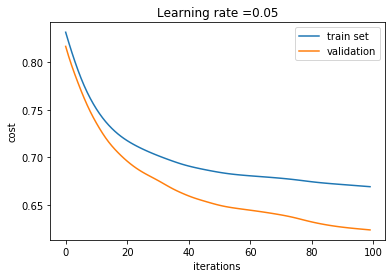

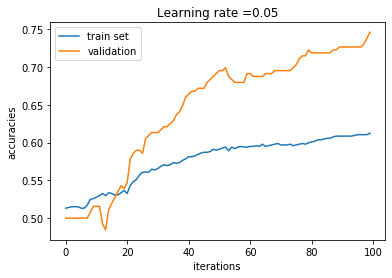

In [41]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')

In [52]:
#define layers
layers_dim = [10000, 10, 5, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(tanh())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=2000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

***********
**********334.3372838497162


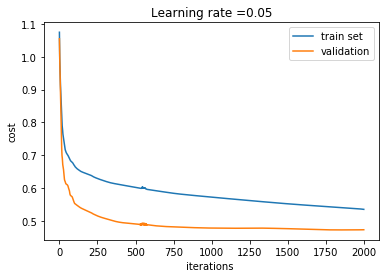

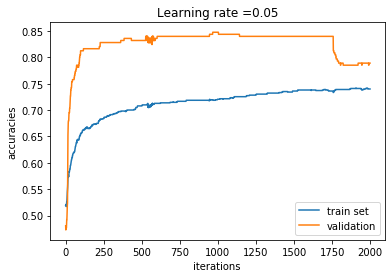

********** the result of activation tanh function ***************
last accuracy of train      : 0.7400194741966893
last accuracy of validation : 0.7890625
last loss of train          : 0.5348031702084162
last loss of validation     : 0.47267217600143063


In [53]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation tanh function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

In [54]:
#define layers
layers_dim = [10000, 10, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(tanh())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=2000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

***********
**********
335.59564232826233


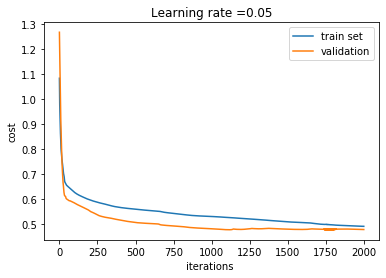

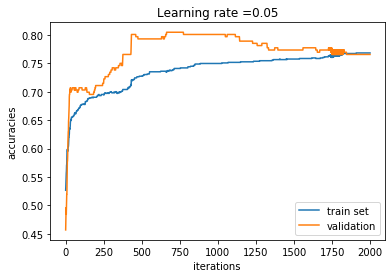

********** the result of activation tanh function ***************
last accuracy of train      : 0.7682570593963
last accuracy of validation : 0.765625
last loss of train          : 0.49175201274496977
last loss of validation     : 0.47896088194095504


In [55]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation tanh function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

In [56]:
#define layers
layers_dim = [10000, 100, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(tanh())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=3000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

****************
***************
1381.5370302200317


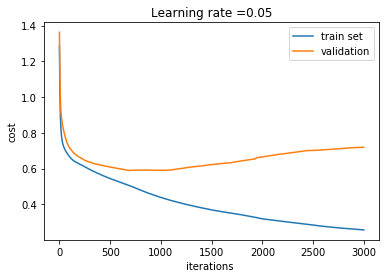

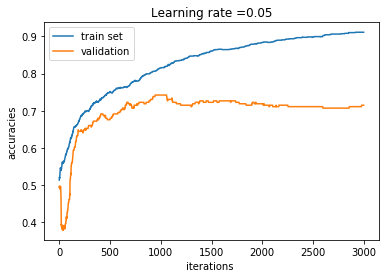

********** the result of activation tanh function ***************
last accuracy of train      : 0.9113924050632911
last accuracy of validation : 0.71484375
last loss of train          : 0.25698653692977863
last loss of validation     : 0.7188518349754262


In [57]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation tanh function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

In [58]:
#define layers
layers_dim = [10000, 100, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(tanh())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=1000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

******
*****
487.532577753067


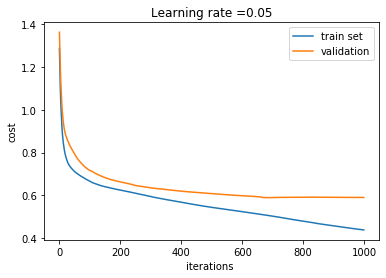

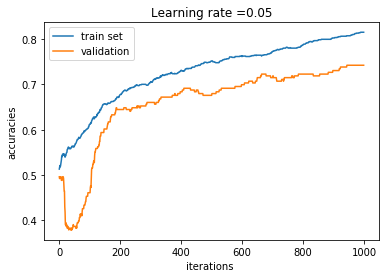

********** the result of activation tanh function ***************
last accuracy of train      : 0.8149951314508277
last accuracy of validation : 0.7421875
last loss of train          : 0.43870748958728417
last loss of validation     : 0.5903318972929524


In [59]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation tanh function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))


*
17.22110152244568


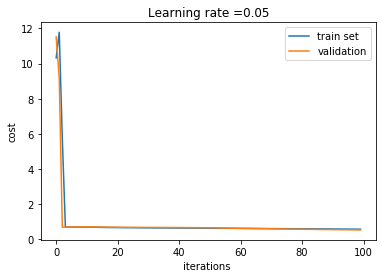

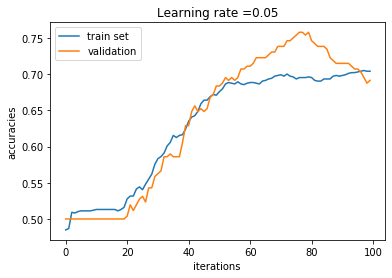

********** the result of activation tanh function ***************
last accuracy of train      : 0.7039922103213242
last accuracy of validation : 0.69140625
last loss of train          : 0.5772041052916602
last loss of validation     : 0.536154414109604


In [40]:
#define layers
layers_dim = [10000, 5, 3, 1]

activations = []

#activation function = relu()
for i in range(len(layers_dim)-2):
    activations.append(leaky_relu())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=100, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation tanh function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

*
*
34.37645125389099


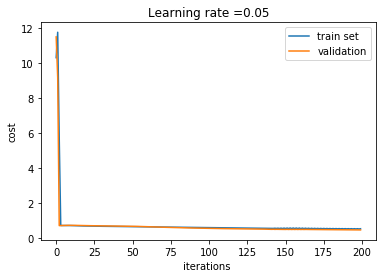

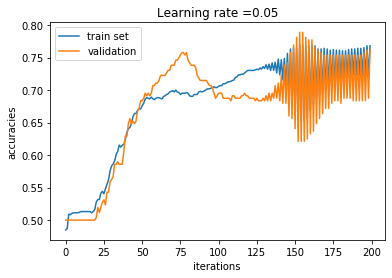

********** the result of activation tanh function ***************
last accuracy of train      : 0.7682570593963
last accuracy of validation : 0.76171875
last loss of train          : 0.5136899200310747
last loss of validation     : 0.44557341209125123


In [43]:
#define layers
layers_dim = [10000, 5, 3, 1]

activations = []

#activation function = relu()
for i in range(len(layers_dim)-2):
    activations.append(leaky_relu())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=200, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation tanh function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

*
*
32.664493799209595


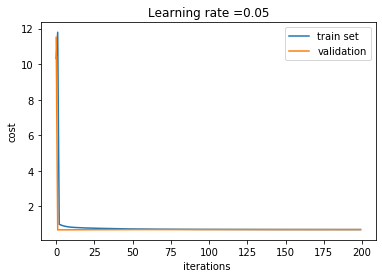

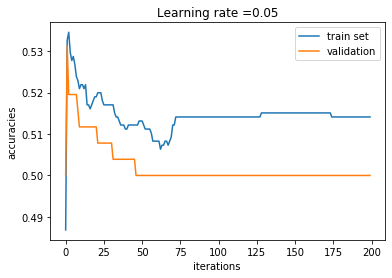

********** the result of activation relu function ***************
last accuracy of train      : 0.5141187925998053
last accuracy of validation : 0.5
last loss of train          : 0.6945859800061601
last loss of validation     : 0.693624827167397


In [46]:
#define layers
layers_dim = [10000, 5, 3, 1]

activations = []

#activation function = relu()
for i in range(len(layers_dim)-2):
    activations.append(relu())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=200, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation relu function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

## 3-nn model best accuracy(sigmoid)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.234|0.894|
|   validation    |0.3617|0.878|

* n_hiddenLayer1 = 10
* n_hiddenLayer2 = 10
* batch_size     = 128
* learning_rate  = 0.05
* iteration time = 1826
* It took 314 seconds.

## 3-nn model best accuracy(tanh)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.438|0.814|
|   validation    |0.590|0.742|

* n_hiddenLayer1 = 100
* n_hiddenLayer2 = 10
* learning_rate  = 0.05
* iteration time = 1000
* It took 487 seconds.

## 3-nn model best accuracy(relu)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.694|0.514|
|   validation    |0.693|0.5|

* n_hiddenLayer1 = 5
* n_hiddenLayer2 = 3
* learning_rate  = 0.05
* iteration time = 200
* It took 32 seconds.



## 3-nn model best accuracy(leacky_relu)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.513|0.768|
|   validation    |0.445|0.761|

* n_hiddenLayer1 = 5
* n_hiddenLayer2 = 3
* learning_rate  = 0.05
* iteration time = 200
* It took 43 seconds.

